# Predicting Cointegration in Cryptocurrency Prices

## Introduction

One popular trading strategy is pairs trading, whereby two assets that move at a similar trajectory are traded when a discrepancy in price is detected. For example, suppose the price of Pepsi stock is typically two times the price of Coca Cola stock, but you see one day that the ratio of prices is not two but three. This suggests that Pepsi is overpriced and Coca Cola is underpriced, so you sell Pepsi stock and buy Coca Cola stock, then hold until the multiple of two is reestablished. 

This assumes that the pairs will move back to their long-run "spread" after some amount of time. However, it is not guaranteed that the prices will maintain their relationship, and predicting whether or not they do is the goal of this project.

## Cryptocurrencies

We chose to use cryptocurrencies because they are traded at all times (providing a more continuous time frame), it is easy to get very granular data, and because there is much interest in the area right now generally speaking. The data comes from the Binance exchange and is downloaded using [their API](https://github.com/binance-exchange/binance-official-api-docs/blob/master/rest-api.md). For this project, we look at relationships quoted in USD, but data is available quoted in Bitcoin (BTC) and other cryptocurrencies as well. The primary relationship we look at is that between Bitcoin (BTC) and Ethereum (ETH) prices.

### Data

For convenience, I have packaged much of the code I use on this project into a module. The data from Binance is in 15 minute intervals and filtered to cryptocurrencies with at least 30,000 observations.

In [552]:
from core.utils import get_dfs, get_good_dfs, get_close_prices
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

dfs = get_dfs("data")
good_dfs = get_good_dfs(dfs, 30000)
closes = get_close_prices(good_dfs)
closes.head()

,ZECETH,TRXETH,XRPETH,BNBBTC,EOSETH,LTCBNB,ADABTC,EOSBNB,LTCETH,XRPBNB,...,EOSBTC,BNBETH,XRPBTC,DASHBTC,EOSUSDT,XMRBTC,ADAETH,ADAUSDT,XRPUSDT,LTCBTC
time,,,,,,,,,,,,,,,,,,,,,
2018-06-11 11:30:00+00:00,0.37205,0.000090,0.001085,0.002203,0.021298,7.17,0.000026,0.7636,0.20085,0.03872,...,0.001677,0.027988,0.000085,0.040191,11.3498,0.020349,0.000325,0.17274,0.57663,0.015782
2018-06-11 11:45:00+00:00,0.37247,0.000090,0.001084,0.002211,0.021300,7.15,0.000026,0.7600,0.20050,0.03882,...,0.001680,0.028056,0.000085,0.040079,11.3799,0.020455,0.000325,0.17315,0.57841,0.015775
2018-06-11 12:00:00+00:00,0.37259,0.000089,0.001085,0.002203,0.021323,7.15,0.000025,0.7578,0.20033,0.03848,...,0.001676,0.027979,0.000085,0.039889,11.3400,0.020329,0.000323,0.17165,0.57586,0.015780
2018-06-11 12:15:00+00:00,0.37257,0.000089,0.001083,0.002192,0.021271,7.20,0.000025,0.7644,0.20012,0.03885,...,0.001672,0.027871,0.000085,0.039880,11.2840,0.020312,0.000322,0.17100,0.57455,0.015770
2018-06-11 12:30:00+00:00,0.37414,0.000089,0.001086,0.002173,0.021336,7.26,0.000025,0.7701,0.20114,0.03927,...,0.001675,0.027627,0.000085,0.039793,11.2929,0.020360,0.000322,0.17072,0.57595,0.015771


Notice that there are quotes in many different cryptocurrencies (BTC, ETH, USDT, others). Also, there is a problem with the data, initially, which is that there are gaps in the time index - when the exchange is down, for example. These need to be filled in and the dataframe will be filtered to USDT we will have a nice dataframe of prices.

In [21]:
from core.utils import get_pairs, fix_gaps_in_data, calc_log_prices

closes = fix_gaps_in_data(closes)
pairs = get_pairs(good_dfs)
closes_usdt = closes[pairs['USD']]
closes_usdt.head()

,BNBUSDT,LTCUSDT,TRXUSDT,ETHUSDT,BTCUSDT,EOSUSDT,ADAUSDT,XRPUSDT
time,,,,,,,,
2018-06-11 11:30:00+00:00,14.8715,106.75,0.04783,531.73,6759.10,11.3498,0.17274,0.57663
2018-06-11 11:45:00+00:00,14.9664,106.95,0.04787,533.54,6770.56,11.3799,0.17315,0.57841
2018-06-11 12:00:00+00:00,14.8808,106.73,0.04755,531.85,6754.61,11.3400,0.17165,0.57586
2018-06-11 12:15:00+00:00,14.8014,106.30,0.04701,531.20,6752.21,11.2840,0.17100,0.57455
2018-06-11 12:30:00+00:00,14.6275,106.45,0.04702,529.47,6738.42,11.2929,0.17072,0.57595


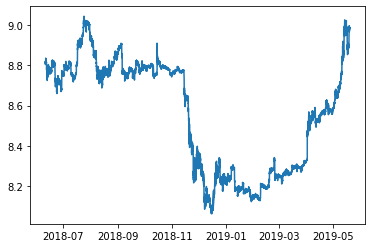

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

log_df = calc_log_prices(closes_usdt)
btc = log_df['BTCUSDT']
eth = log_df['ETHUSDT']
plt.plot(btc)

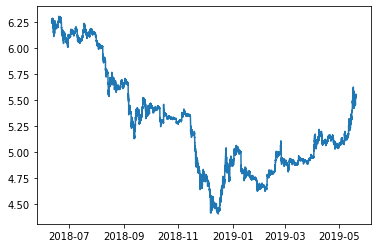

In [34]:
plt.plot(eth)

In [37]:
log_df.corr()

,BNBUSDT,LTCUSDT,TRXUSDT,ETHUSDT,BTCUSDT,EOSUSDT,ADAUSDT,XRPUSDT
BNBUSDT,1.000000,0.902460,0.576787,0.463951,0.504626,0.667636,0.596181,0.070044
LTCUSDT,0.902460,1.000000,0.723886,0.766369,0.750545,0.902008,0.859446,0.357024
TRXUSDT,0.576787,0.723886,1.000000,0.731131,0.464346,0.690890,0.740841,0.424758
ETHUSDT,0.463951,0.766369,0.731131,1.000000,0.844415,0.916609,0.963152,0.610412
BTCUSDT,0.504626,0.750545,0.464346,0.844415,1.000000,0.895844,0.872605,0.578715
EOSUSDT,0.667636,0.902008,0.690890,0.916609,0.895844,1.000000,0.951645,0.621244
ADAUSDT,0.596181,0.859446,0.740841,0.963152,0.872605,0.951645,1.000000,0.569792
XRPUSDT,0.070044,0.357024,0.424758,0.610412,0.578715,0.621244,0.569792,1.000000


## Cointegration

The goal is to know when to and when not to engage in pairs trading, so we need a measure of how well assets move together. To this end, the concept of cointegration is helpful. 

Let $y_t$ and $x_t$ be a pair of $I(1)$ non-stationary time series variables. If there is a *cointegrating factor* $\beta$ such that $y_t + \beta x_t = u_t$ where $u_t$ is a stationary process, then the two series $y_t, x_t$ are said to be cointegrated. For our purposes, $u_t$ can be considered the pricing discrepancy that we will trade on.

### Engle-Granger Two Step Method

One test to determine cointegration is known as the Engle-Granger two step method. The two steps are:

1. Estimate the regression $\hat{y_t} = \hat{\alpha} + \hat{\beta} x_t + \hat{u_t}$
2. Test the residuals $\hat{u_t}$ for a unit root

We use the Dickey-Fuller unit root test for the second step and OLS for the first.

### Cointegration between BTC and ETH

The two assets we want to inspect for cointegration are Bitcoin and Ethereum. For demonstration purposes, I have cherry-picked a period in the time series where they are indeed cointegrated and will prove it below. For the plot, I've scaled the values to be near each other.

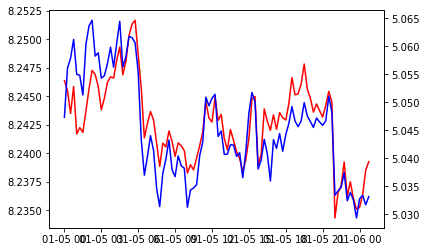

In [506]:
date = '2019-01-05'
start = int(np.where(log_df.index == date)[0])
end = int(np.where(log_df.index == date)[0] + 100)

btc = log_df['BTCUSDT'][start:end]
eth = log_df['ETHUSDT'][start:end]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(btc, color="red")
ax2.plot(eth, color="blue")

To prove this is cointegrated, we do the Engle Granger approach described above

In [507]:
from sklearn.linear_model import LinearRegression

eth_array = np.array(eth).reshape(-1, 1)
btc_array = np.array(btc)

regression = LinearRegression()
regression.fit(eth_array, btc_array)
print(regression.coef_)
print(regression.intercept_)

[0.34100285]
6.522231543054636


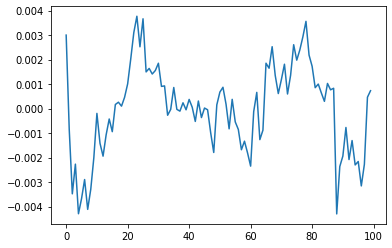

In [508]:
btc_hat = regression.predict(eth_array)
residuals = btc_array - btc_hat
plt.plot(residuals)

We can see that the residuals of the model are mean reverting, and now we test this using the Dickey Fuller test

In [226]:
import statsmodels.tsa.stattools as ts
ts.adfuller(residuals)

(-3.6553909792347588,
 0.004786215496236841,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 -947.9629448288958)

The first value is the test statistic from the Dickey Fuller test, and the second is the p-value. As we can see, the two time series are cointegrated at the 1% level.

Suppose you were partying all night and slept the entire day, so your trading started at 5:30 in the afternoon rather than midnight on 2019-01-05. At this time, we find an example of non-cointegration between BTC and ETH.

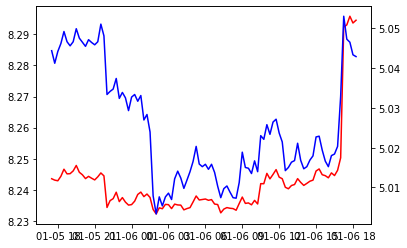

In [503]:
date = '2019-01-05 17:30:00+0000'
start = int(np.where(log_df.index == date)[0])
end = int(np.where(log_df.index == date)[0] + 100)

btc = log_df['BTCUSDT'][start:end]
eth = log_df['ETHUSDT'][start:end]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(btc, color="red")
ax2.plot(eth, color="blue")

The point is that there are less cross overs with this and therefore less pair trading opportunities.

In [500]:
eth_array = np.array(eth).reshape(-1, 1)
btc_array = np.array(btc)

regression = LinearRegression()
regression.fit(eth_array, btc_array)
print(regression.coef_)
print(regression.intercept_)

[0.48359667]
5.81230086220989


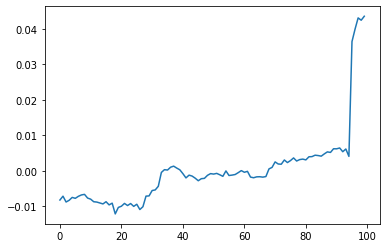

In [501]:
btc_hat = regression.predict(eth_array)
residuals = btc_array - btc_hat
plt.plot(residuals)

In [504]:
ts.adfuller(residuals)

(1.0846729767379113,
 0.9950836663843439,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 -729.7914766563806)

The residuals are clearly non-stationary with this period

## Rolling Analysis

In the above example, the period of analysis is 100 observations of 15 minute observations. The question of interest is how this data changes over time. To accomplish this, we construct both the target variable and the features for the machine learning models using a rolling calculation.

In [509]:
from core.rolling_analysis import RollingAnalyzer

m = 100

rolling_analyzer = RollingAnalyzer(log_df, m)
rolling_analyzer.make_dfs()
rolling_analyzer.asset_loop()
rolling_analyzer.run_regressions('ETHUSDT', 'BTCUSDT')
rolling_analyzer.calc_dickey_fuller('ETHUSDT', 'BTCUSDT')

### Response variable: the p-value of the Dickey Fuller Test

The goal is to identify the windows of time when the pairs trading strategy makes the most sense, so the target variable chosen is the p-value of the Dickey-Fuller test. This has already been calculated and can be exported now to a dataframe, then plotted.

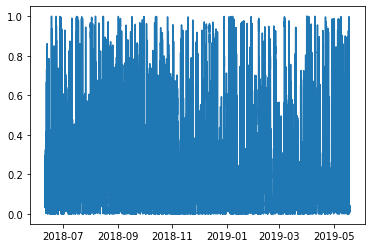

In [512]:
dickey_fuller_roll = rolling_analyzer.export_dickey_fuller_df()
plt.plot(dickey_fuller_roll)

This is clearly a mess, so I will zoom in on a shorter period of time (first week of 2019)

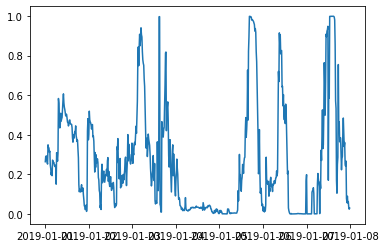

In [513]:
plt.plot(dickey_fuller_roll['2019-01-01':'2019-01-07'])

Notice that value is between 0 and 1 because it is a p-value. We can transform this to be between negative infinity and infinity using the same transformation as in the logistic regression

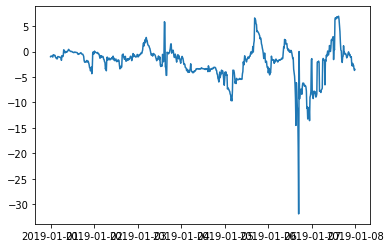

In [553]:
def to_infinity(x):
    return np.log(x/(1-x))
    
df_infinity = to_infinity(dickey_fuller_roll).replace([np.inf, -np.inf], 0)
plt.plot(df_infinity['2019-01-01':'2019-01-07'])

This is the target variable we would like to forecast using machine learning.

Because this is a rolled time series, we expect autocorrelation

(0, 110)

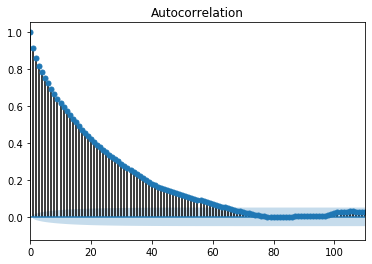

In [556]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_infinity)
plt.xlim(0, 110)

Clearly this can easily be forecast already because of the autocorrelation. However, because of the rolling, we wish to forecast the next step *by the rolling window* and not simply one observation ahead. From the autocorrelation plot, we see there is little correlation between the current p-value and the one 100 observations away.

### Feature variables: rolled statistics

We now introduce the other features besides lagged p-values for the machine learning models. These are calculated as rolled mean returns and volatility over the same period. 

In [565]:
rolling_analyzer.calc_all_returns_stats()
mean_returns_df = rolling_analyzer.export_returns_stats_df(stat='mean_return')
volatility_df = rolling_analyzer.export_returns_stats_df(stat='volatility')

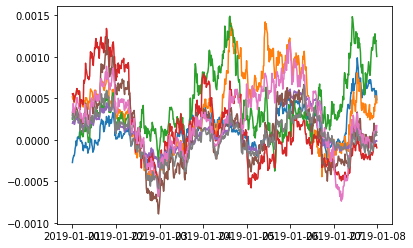

In [568]:
plt.plot(mean_returns_df['2019-01-01':'2019-01-07'])

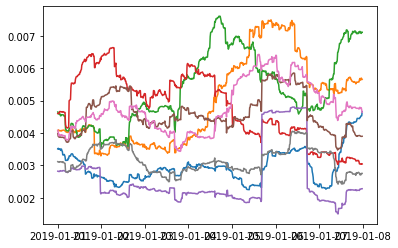

In [570]:
plt.plot(volatility_df['2019-01-01':'2019-01-07'])

There are many statistics that can be generated for use as features with the rolling period - Sharpe ratio, skewness and kurtosis, correlation, etc. We can even produce the rolled cointegration measures for the other asset pairs and use that as a feature to the model. Whether or not these features produce any explanatory power in future cointegration is the goal of the project.